#### Description
This Notebook contains CNN model for cogntive load classification. The dataset used contains $44000$ images from four levels of cognitive load $11000$ from each. Images are spatial-spectral representation of EEG data recorded from subjects (11 people) taking a working memory test.

I implemented a simple CNN model to cogntive load classification. The model was designed using Keras library which used tensorflow as backend.

In [7]:
from tensorflow import keras
# from tensorflow.keras import 
from tensorflow.keras.models import load_model
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# from tensorflow.keras.layers.advanced_activations import ELU
from sklearn.utils import class_weight
# from keras.utils.vis_utils import plot_model
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import os
from collections import Counter
import numpy as np
from tensorflow.keras.optimizers import RMSprop, SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.utils.multiclass import unique_labels



### Step: Dataset loading and preparation
Images used are 224 by 224 RGB images. I used a Data genaerator python library to load images. Data generator is useful because it load images batch bay batch during training which prevents from running out memory when we load entire dataset at once. The generator also perfoms data augmentation by modifying images by simple rotation, scaling,etc, which helps control overfitting.


In [8]:

num_classes = 4
img_rows, img_cols = 224,224
batch_size =32
train_data_dir = "/home/kashraf/Journal_work_Fall2021/GAN_topomap/topos_GAN+REAL/theta/train_test/train/"
validation_data_dir ="/home/kashraf/Journal_work_Fall2021/GAN_topomap/topos_GAN+REAL/theta/train_test/test/"

# Data generator to load the data for training and test dataset
train_datagen = ImageDataGenerator()

validation_datagen = ImageDataGenerator()
 
    # loading training images from path
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_rows, img_cols),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True)
    
    # Loading test images from path
validation_generator = validation_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_rows, img_cols),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False)

Found 30800 images belonging to 4 classes.
Found 13200 images belonging to 4 classes.


In [12]:
nb_train_samples =30800
nb_validation_samples =13200 

### Step 3: Designing model architrecture

In [19]:
model = Sequential()

# First conv,max pool, batch normalizatio layer with relu activation function
model.add(Conv2D(32, (7, 7), padding = 'same', input_shape = (img_rows, img_cols,3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# First conv,max pool (poolsize=2), batch normalizatio layer with relu activation function 
model.add(Conv2D(64, (5, 5), padding = "same"))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(96, (3, 3), padding="same"))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

model.add(Conv2D(128, (3, 3), padding="same",kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(256, (3, 3), padding="same",kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(256, (3, 3), padding="same",kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())

## Flatten features to form dense layer with 0.4 dropout layer
model.add(Dense(1024))
model.add(Activation('relu'))
model.add(Dropout(0.4))


# SOftmax layer for classification 
model.add(Dense(num_classes,activation='softmax',name='mbm'))

print("Model summary:\n",model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 224, 224, 32)      4736      
_________________________________________________________________
batch_normalization_6 (Batch (None, 224, 224, 32)      128       
_________________________________________________________________
activation_7 (Activation)    (None, 224, 224, 32)      0         
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 112, 112, 64)      51264     
_________________________________________________________________
batch_normalization_7 (Batch (None, 112, 112, 64)      256       
_________________________________________________________________
activation_8 (Activation)    (None, 112, 112, 64)     

### Step4: Model Training
Model was trained for $100$.

In [13]:
             
checkpoint = ModelCheckpoint("/home/kashraf/Research_2021/saved_models/cnn_theta_ganreal_nov11-v1.h5",
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)

earlystop = EarlyStopping(monitor = 'val_loss', 
                          min_delta = 0, 
                          patience = 7,
                          verbose = 1,
                          restore_best_weights = True)

reduce_lr = ReduceLROnPlateau(monitor = 'val_loss',
                              factor = 0.2,
                              patience = 3,
                              verbose = 1,
                              min_delta = 0.000001)

# we put our call backs into a callback list
callbacks = [ checkpoint,reduce_lr]

# We use a very small learning rate 
model.compile(loss = 'categorical_crossentropy',
              optimizer = Adam(learning_rate=0.0001),
              metrics = ['accuracy'])


epochs = 100

history= model.fit(   
    
    train_generator,
    steps_per_epoch = nb_train_samples // batch_size,
    epochs = epochs,
    callbacks = callbacks,
    validation_data = validation_generator,
    validation_steps = nb_validation_samples // batch_size)

Epoch 1/100
962/962 [==============================] - ETA: 0s - loss: 5.5789 - accuracy: 0.4871
Epoch 00001: val_loss improved from inf to 5.32179, saving model to /home/kashraf/Research_2021/saved_models/cnn_theta_ganreal_nov11-v1.h5
962/962 [==============================] - 63s 66ms/step - loss: 5.5789 - accuracy: 0.4871 - val_loss: 5.3218 - val_accuracy: 0.4522 - lr: 1.0000e-04
Epoch 2/100
962/962 [==============================] - ETA: 0s - loss: 3.2287 - accuracy: 0.6443
Epoch 00002: val_loss did not improve from 5.32179
962/962 [==============================] - 62s 65ms/step - loss: 3.2287 - accuracy: 0.6443 - val_loss: 10.4277 - val_accuracy: 0.2519 - lr: 1.0000e-04
Epoch 3/100
962/962 [==============================] - ETA: 0s - loss: 1.8213 - accuracy: 0.6630
Epoch 00003: val_loss did not improve from 5.32179
962/962 [==============================] - 62s 65ms/step - loss: 1.8213 - accuracy: 0.6630 - val_loss: 14.5806 - val_accuracy: 0.2491 - lr: 1.0000e-04
Epoch 4/100
962/

Epoch 50/100
962/962 [==============================] - ETA: 0s - loss: 0.2406 - accuracy: 0.9679
Epoch 00050: val_loss did not improve from 0.44564
962/962 [==============================] - 62s 65ms/step - loss: 0.2406 - accuracy: 0.9679 - val_loss: 0.4490 - val_accuracy: 0.8916 - lr: 1.0240e-11
Epoch 51/100
962/962 [==============================] - ETA: 0s - loss: 0.2403 - accuracy: 0.9686
Epoch 00051: val_loss did not improve from 0.44564
962/962 [==============================] - 62s 65ms/step - loss: 0.2403 - accuracy: 0.9686 - val_loss: 0.4492 - val_accuracy: 0.8917 - lr: 1.0240e-11
Epoch 52/100
962/962 [==============================] - ETA: 0s - loss: 0.2385 - accuracy: 0.9674
Epoch 00052: val_loss did not improve from 0.44564

Epoch 00052: ReduceLROnPlateau reducing learning rate to 2.0479997905886727e-12.
962/962 [==============================] - 62s 65ms/step - loss: 0.2385 - accuracy: 0.9674 - val_loss: 0.4491 - val_accuracy: 0.8918 - lr: 1.0240e-11
Epoch 53/100
961/962 

961/962 [============================>.] - ETA: 0s - loss: 0.2389 - accuracy: 0.9695
Epoch 00100: val_loss did not improve from 0.44564

Epoch 00100: ReduceLROnPlateau reducing learning rate to 1.3421772842561475e-23.
962/962 [==============================] - 62s 65ms/step - loss: 0.2389 - accuracy: 0.9695 - val_loss: 0.4491 - val_accuracy: 0.8914 - lr: 6.7109e-23


In [3]:
model=load_model("cnn_theta_ganjun28-v1.h5")


## Performance Analysis

In [9]:
import matplotlib.pyplot as plt
import sklearn
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# We need to recreate our validation generator with shuffle = false
validation_generator = validation_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False)

class_labels = validation_generator.class_indices
class_labels = {v: k for k, v in class_labels.items()}
classes = list(class_labels.values())
nb_train_samples = 29328
nb_validation_samples = 14672


#Confution Matrix and Classification Report
Y_pred = model.predict_generator(validation_generator, nb_validation_samples // batch_size)
y_pred = np.argmax(Y_pred, axis=1)
print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))

class_names=np.asarray(['CL-2','CL-4','CL-6','CL-8'])
# Plot non-normalized confusion matrix



Found 13200 images belonging to 4 classes.
Classification Report
              precision    recall  f1-score   support

         cl2       0.89      0.92      0.91      3300
         cl4       0.89      0.92      0.91      3300
         cl6       0.85      0.82      0.84      3300
         cl8       0.92      0.90      0.91      3300

    accuracy                           0.89     13200
   macro avg       0.89      0.89      0.89     13200
weighted avg       0.89      0.89      0.89     13200



In [14]:
Y_test=validation_generator.classes
Y_test

array([0, 0, 0, ..., 3, 3, 3], dtype=int32)

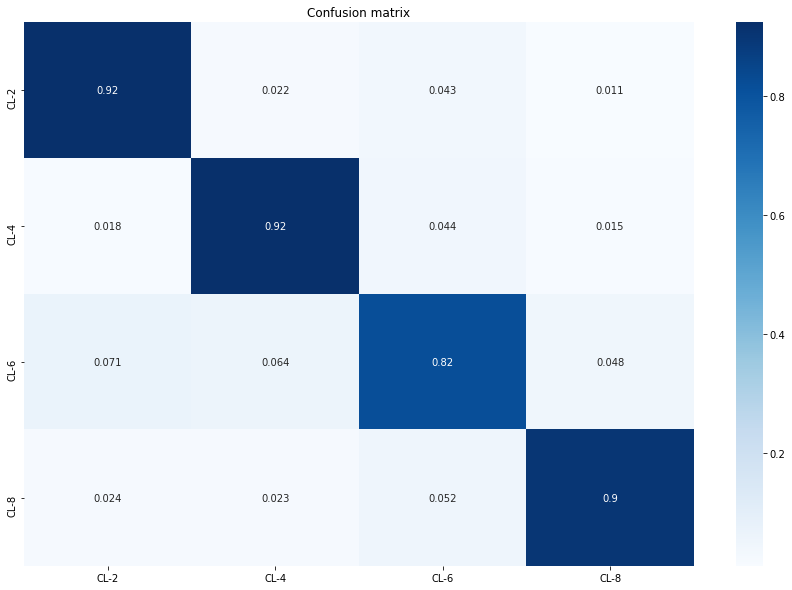

In [16]:
import seaborn as sr
import pandas as pd

conf=confusion_matrix(Y_test,y_pred,normalize="true")
conf_df=pd.DataFrame(conf, index=class_names, columns=class_names)
# print("\nFace  accuracy =",accuracy)
# print("\n Classification report: \n",report)
fig=plt.figure(figsize=(15,10))
sr.heatmap(conf_df,annot=True,cmap="Blues")
plt.title("Confusion matrix")
plt.savefig("Gan_theta_conf_mat.png")
plt.show()

### Plotting our Accuracy and Loss Charts

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


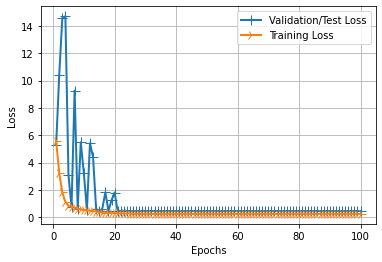

In [16]:

print(history.history.keys())
# Plotting our loss charts
import matplotlib.pyplot as plt

history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)

line1 = plt.plot(epochs, val_loss_values, label='Validation/Test Loss')
line2 = plt.plot(epochs, loss_values, label='Training Loss')
plt.setp(line1, linewidth=2.0, marker = '+', markersize=10.0)
plt.setp(line2, linewidth=2.0, marker = '4', markersize=10.0)
plt.xlabel('Epochs') 
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.savefig('Loss_theta.png', dpi = 1200)
plt.show()

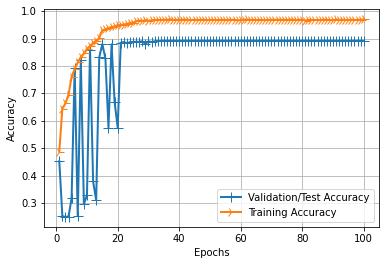

In [17]:
# Plotting our accuracy charts
import matplotlib.pyplot as plt

history_dict = history.history
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
epochs = range(1, len(loss_values) + 1)
line1 = plt.plot(epochs, val_acc_values, label='Validation/Test Accuracy')
line2 = plt.plot(epochs, acc_values, label='Training Accuracy')
plt.setp(line1, linewidth=2.0, marker = '+', markersize=10.0)
plt.setp(line2, linewidth=2.0, marker = '4', markersize=10.0)
plt.xlabel('Epochs') 
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.savefig('Accuracy_theta.png', dpi = 1200)
plt.show()